# Demonstration of how to access EMODnet Physics data relative to River flow rate and Sea level with Python

This notebook shows how to access EMODnet Physics data and will specifically query and analyze data regarding two parameters: RVFL (river flow rate), and SLEV (sea level). These two parameters were chosen as example to analyze from different observation points an extreme climatic event.

The data is hosted on EMODnet Physics's ERDDAP, found at https://ercompwebapps.emodnet-physics.eu/erddap/index.html

The first thing to do is import the libraries that will be used by the following cell codes. If the notebook is executed outside Google Colab's environment these libraries will have to be installed.

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium.plugins import MarkerCluster

## Analysis of River flow rate data from stations near Valencia from 2024-10-01 to 2024-11-30

In this example the two river stations that have been chosen to show the variation over time in the flow rate are:

- RS_ES_Palancia_FuenteDelBano
- RS_ES_Jucar_HuertoDeMulet

The code cell below will get the coordinates for these stations from ERDDAP and show their position on a map.

In [11]:
station_codes_rvfl = ['RS_ES_Palancia_FuenteDelBano', 'RS_ES_Jucar_HuertoDeMulet']
min_time = '2024-10-01'
max_time = '2024-11-30'

# initializing the map on the Valencia area
map_rvfl = folium.Map(location=[39.5, -0.5], zoom_start=9, width='700px')

marker_cluster = MarkerCluster().add_to(map_rvfl)

station_codes_rvfl_query = '=~%22(' + f'%7C'.join([f'{station_code}' for station_code in station_codes_rvfl]) + ')%22'

coords_rvfl_url = f'https://ercompwebapps.emodnet-physics.eu/erddap/tabledap/TS_RVFL.csv?PLATFORMCODE%2Clatitude%2Clongitude&PLATFORMCODE{station_codes_rvfl_query}&distinct()'

# making the request to erddap, using the url, to get the coordinates of the stations and loading the response in a pandas DataFrame
df_coords_rvfl = pd.read_csv(coords_rvfl_url, skiprows=[1])

# adding the markers in the map to show the location of the stations
for index, row in df_coords_rvfl.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    platform_code = row['PLATFORMCODE']

    folium.Marker(
        [latitude, longitude],
        popup=f'Station: {platform_code}'
    ).add_to(marker_cluster)

display(map_rvfl)

As can be seen from the map we will be analyzing the river flow rate data from two rivers around Valencia from 2024-10-01 to 2024-11-30.

The next code cell will make the request for the RVFL data for the selected period of time for both the stations.
The data downloaded in csv format will be loaded in a pandas DataFrame and displayed.

In [25]:
# creating the url with the necessary query and filters
data_rvfl_url = (
    f'https://ercompwebapps.emodnet-physics.eu/erddap/tabledap/TS_RVFL.csv?'
    f'PLATFORMCODE%2Ctime%2CRVFL&'
    f'PLATFORMCODE{station_codes_rvfl_query}&'
    f'time%3E={min_time}T00%3A00%3A00Z&'
    f'time%3C={max_time}T01%3A00%3A00Z'
)
# making the request for the data and loading it into a pandas DataFrame
df_data_rvfl = pd.read_csv(data_rvfl_url)

display(df_data_rvfl)

,PLATFORMCODE,time,RVFL
0,NaN,UTC,m3/s
1,RS_ES_Jucar_HuertoDeMulet,2024-10-01T22:00:00Z,6.707
2,RS_ES_Jucar_HuertoDeMulet,2024-10-02T22:00:00Z,6.781
3,RS_ES_Jucar_HuertoDeMulet,2024-10-03T22:00:00Z,6.524
4,RS_ES_Jucar_HuertoDeMulet,2024-10-04T22:00:00Z,7.332
...,...,...,...
113,RS_ES_Palancia_FuenteDelBano,2024-11-25T23:00:00Z,0.155
114,RS_ES_Palancia_FuenteDelBano,2024-11-26T23:00:00Z,0.156
115,RS_ES_Palancia_FuenteDelBano,2024-11-27T23:00:00Z,0.157
116,RS_ES_Palancia_FuenteDelBano,2024-11-28T23:00:00Z,0.158


In this last code cell the data will be used to generate two plots.
These will show the variations in river flow rate (expressed in m³/s) over time.

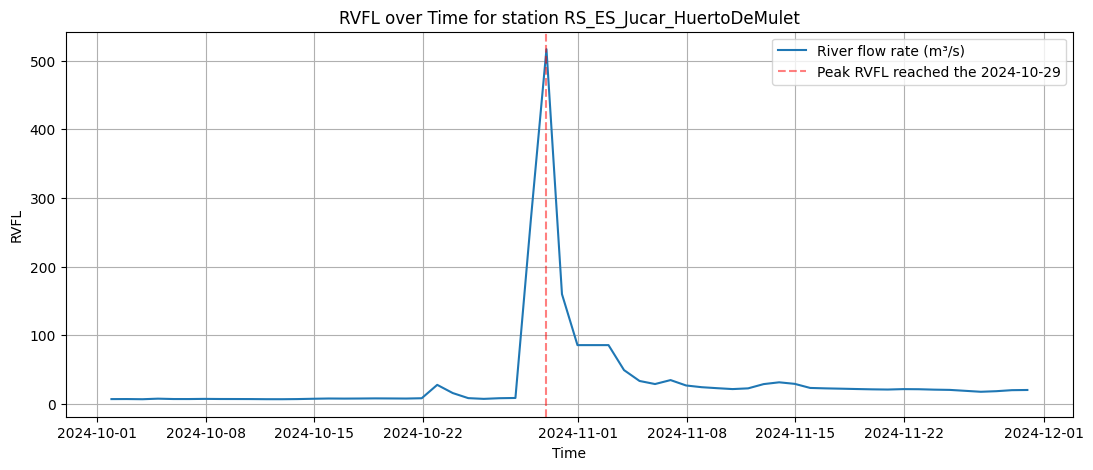

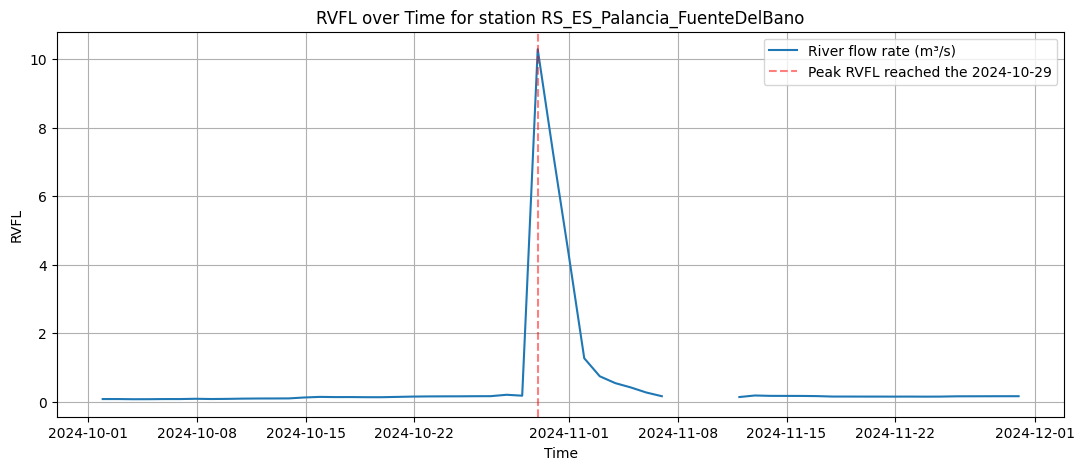

In [27]:
# extracting the unit of measurement from the DataFrame
unit_of_measurement_rvfl = None
if 'SLEV' in df_data_rvfl.columns and not unit_of_measurement_rvfl:
  unit_of_measurement_rvfl =  df_data_rvfl['RVFL'].iloc[0]

# data cleaning
df_data_rvfl = df_data_rvfl[1:].copy()
df_data_rvfl.loc[:, 'time'] = pd.to_datetime(df_data_rvfl['time'])
df_data_rvfl.loc[:, 'RVFL'] = pd.to_numeric(df_data_rvfl['RVFL'])

# grouping the DataFrame by station
platformcode_groups = {platform_code: df for platform_code, df in df_data_rvfl.groupby('PLATFORMCODE')}

# plotting each station's river flow rate over time and highlighting the maximum RVFL reached
for platform_code, df in platformcode_groups.items():
    plt.figure(figsize=(13, 5))
    plt.plot(df['time'], df['RVFL'], label='River flow rate (m³/s)')
    peak_rvfl = df['time'][df['RVFL'].idxmax()]
    peak_rvfl_day = peak_rvfl.strftime('%Y-%m-%d')
    plt.axvline(x=peak_rvfl, color='r', label=f'Peak RVFL reached the {peak_rvfl_day}', alpha=0.5, ls='--')
    plt.xlabel('Time')
    plt.ylabel('RVFL')
    plt.title(f'RVFL over Time for station {platform_code}')
    plt.legend()
    plt.grid(True)
    plt.show()

A third station has been omitted from the data process above. It is the station
- RS_ES_Turia_LaPresa

We'll briefly repeat the process above to show the data it recorded.

In [23]:
url_turia_coords = f'https://ercompwebapps.emodnet-physics.eu/erddap/tabledap/TS_RVFL.csv?PLATFORMCODE%2Clatitude%2Clongitude&PLATFORMCODE=%22RS_ES_Turia_LaPresa%22&distinct()'

df_coords_turia = pd.read_csv(url_turia_coords, skiprows=[1])

turia_latitude = df_coords_turia['latitude'][0]
turia_longitude = df_coords_turia['longitude'][0]

map_turia = folium.Map(location=[39.5, -0.5], zoom_start=11, width='700px')

marker_cluster = MarkerCluster().add_to(map_turia)

folium.Marker(
    [turia_latitude, turia_longitude],
    popup=f'Station: RS_ES_Turia_LaPresa'
).add_to(marker_cluster)

display(map_turia)

The station, recording river flow rate data for the river Turia, is the closest to the city of Valencia. We'll now download the data for this station and visualize it.

In [19]:
data_turia_url = (
    f'https://ercompwebapps.emodnet-physics.eu/erddap/tabledap/TS_RVFL.csv?'
    f'PLATFORMCODE%2Ctime%2CRVFL&'
    f'PLATFORMCODE=%22RS_ES_Turia_LaPresa%22&'
    f'time%3E={min_time}T00%3A00%3A00Z&'
    f'time%3C={max_time}T01%3A00%3A00Z'
)
# making the request for the data and loading it into a pandas DataFrame
df_turia_rvfl = pd.read_csv(data_turia_url)

display(df_turia_rvfl)

,PLATFORMCODE,time,RVFL
0,NaN,UTC,m3/s
1,RS_ES_Turia_LaPresa,2024-10-02T22:00:00Z,NaN
2,RS_ES_Turia_LaPresa,2024-10-03T22:00:00Z,3.635
3,RS_ES_Turia_LaPresa,2024-10-04T22:00:00Z,3.439
4,RS_ES_Turia_LaPresa,2024-10-05T22:00:00Z,2.972
5,RS_ES_Turia_LaPresa,2024-10-06T22:00:00Z,3.919
6,RS_ES_Turia_LaPresa,2024-10-07T22:00:00Z,3.974
7,RS_ES_Turia_LaPresa,2024-10-08T22:00:00Z,4.295
8,RS_ES_Turia_LaPresa,2024-10-09T22:00:00Z,4.174
9,RS_ES_Turia_LaPresa,2024-10-10T22:00:00Z,NaN


We can see already that something is wrong with the data. By looking at the 'time' column we notice that the measurements from 2024-10-29 to 2024-11-11 are missing. Additionally we can see a few NaN (Not a Number) values in the RVFL column and three rows that have a repeated value of 2761.631 m3/s. We'll generate a plot to have a visual representation of the data.

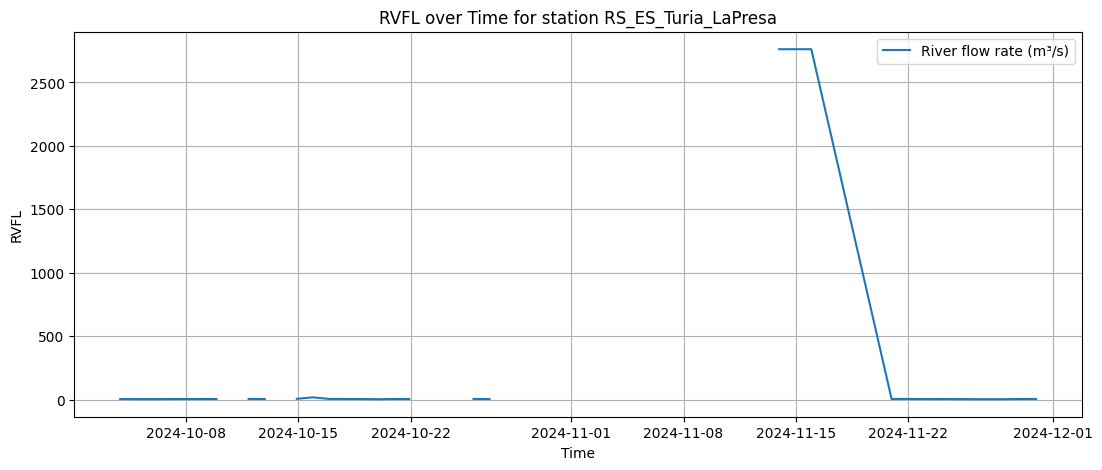

In [21]:
df_turia_rvfl = df_turia_rvfl[1:].copy()
df_turia_rvfl.loc[:, 'time'] = pd.to_datetime(df_turia_rvfl['time'])
df_turia_rvfl.loc[:, 'RVFL'] = pd.to_numeric(df_turia_rvfl['RVFL'])

plt.figure(figsize=(13, 5))
plt.plot(df_turia_rvfl['time'], df_turia_rvfl['RVFL'], label='River flow rate (m³/s)')
plt.xlabel('Time')
plt.ylabel('RVFL')
plt.title(f'RVFL over Time for station RS_ES_Turia_LaPresa')
plt.legend()
plt.grid(True)
plt.show()

By plotting the data it appears even clearer that something happened to this station during the flooding that hit Valencia at the end of October 2024.

We'll now approach the same event from a different perspective.

## Analysis of Sea level data from stations near Valencia from 2024-10-01 to 2024-11-30

The same logic will now be used to analyze the sea level data (SLEV) from two stations near Valencia. The stations that have been chosen in this case are:

- ValenciaTG
- vale

As first step the geographical position of the two stations will be plotted on a map.

In [28]:
station_codes_slev = ['vale', 'ValenciaTG']
min_time = '2024-10-01'
max_time = '2024-11-30'

# initializing the map on the Valencia area
map_slev = folium.Map(location=[39.4708, -0.377], zoom_start=12, width='700px')

marker_cluster = MarkerCluster().add_to(map_slev)

station_codes_slev_query = '=~%22(' + f'%7C'.join([f'{station_code}' for station_code in station_codes_slev]) + ')%22'

coords_slev_url = f'https://ercompwebapps.emodnet-physics.eu/erddap/tabledap/TS_SLEV.csv?PLATFORMCODE%2Clatitude%2Clongitude&PLATFORMCODE{station_codes_slev_query}&distinct()'

# making the request to erddap, using the url, to get the coordinates of the stations and loading the response in a pandas DataFrame
df_coords_slev = pd.read_csv(coords_slev_url, skiprows=[1])

# adding the markers to show the location of the stations on the map
for index, row in df_coords_slev.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    platform_code = row['PLATFORMCODE']

    folium.Marker(
        [latitude, longitude],
        popup=f'Station: {platform_code}'
    ).add_to(marker_cluster)

display(map_slev)

Now the data for the selected period of time and for both the stations will be gathered from ERDDAP, downloaded in csv format and loaded into a pandas DataFrame.

The downloading process in this case may take a bit longer because, as will be seen from the DataFrame, the frequency of the data is of one measurement for each minute.

In [33]:
# creating the url with the necessary query and filters
data_slev_url = (
    f'https://ercompwebapps.emodnet-physics.eu/erddap/tabledap/TS_SLEV.csv?'
    f'PLATFORMCODE%2Ctime%2CSLEV'
    f'&PLATFORMCODE{station_codes_slev_query}'
    f'&time%3E={min_time}T00%3A00%3A00Z'
    f'&time%3C={max_time}T01%3A00%3A00Z'
)
# making the request for the data and loading it into a pandas DataFrame
df_data_slev = pd.read_csv(data_slev_url)

display(df_data_slev)

,PLATFORMCODE,time,SLEV
0,NaN,UTC,m
1,ValenciaTG,2024-10-01T00:00:00Z,0.23199999332427979
2,ValenciaTG,2024-10-01T00:01:00Z,0.2240000069141388
3,ValenciaTG,2024-10-01T00:02:00Z,0.22699999809265137
4,ValenciaTG,2024-10-01T00:03:00Z,0.22599999606609344
...,...,...,...
161018,vale,2024-11-30T00:56:00Z,0.198
161019,vale,2024-11-30T00:57:00Z,0.198
161020,vale,2024-11-30T00:58:00Z,0.192
161021,vale,2024-11-30T00:59:00Z,0.186


Once the data has been imported into a pandas DataFrame the plots can be generated. As in the river flow rate plots the peak will be highlighted and we can see that also in this case it matches the catastrophic flooding event that took place the 29th of october 2024.

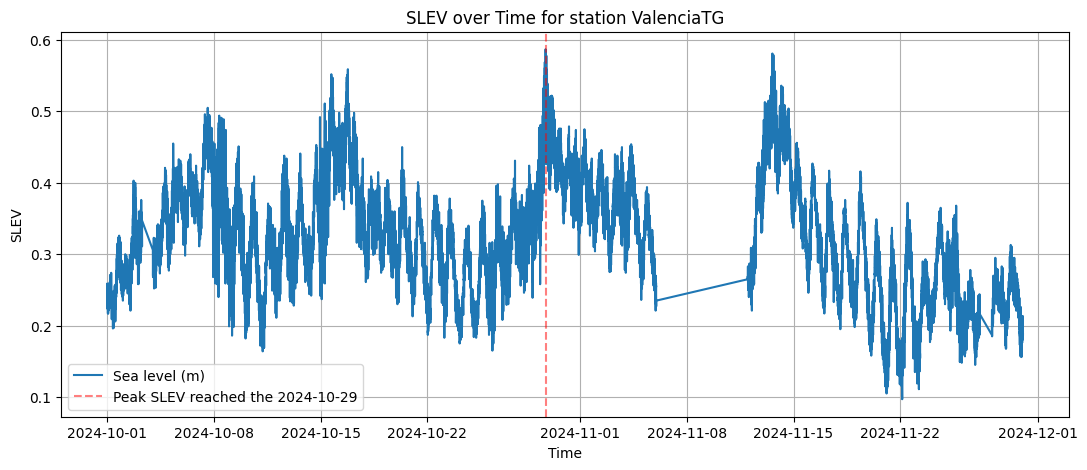

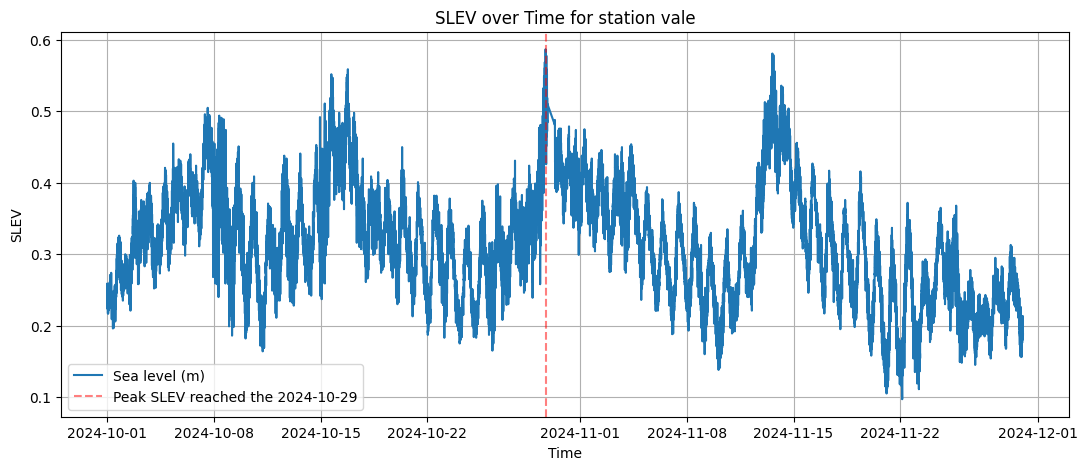

In [34]:
# extracting the unit of measurement from the DataFrame
if pd.isna(df_data_slev['PLATFORMCODE'].iloc[0]) and not str(df_data_slev['SLEV'].iloc[0]).isdigit():
  unit_of_measurement_slev = df_data_slev['SLEV'].iloc[0]

# data cleaning
df_data_slev = df_data_slev[1:].copy()
df_data_slev.loc[:, 'time'] = pd.to_datetime(df_data_slev['time'])
df_data_slev.loc[:, 'SLEV'] = pd.to_numeric(df_data_slev['SLEV'])

# grouping the data by station
platformcode_groups = {platform_code: df for platform_code, df in df_data_slev.groupby('PLATFORMCODE')}

# generating a plot for each of the stations, showing the variations of SLEV over time and highlighting the peak
for platform_code, df in platformcode_groups.items():
    plt.figure(figsize=(13, 5))
    plt.plot(df['time'], df['SLEV'], label=f'Sea level ({unit_of_measurement_slev})')
    peak_slev = df['time'][df['SLEV'].idxmax()]
    peak_slev_day = peak_slev.strftime('%Y-%m-%d')
    plt.axvline(x=peak_slev, color='r', label=f'Peak SLEV reached the {peak_slev_day}', alpha=0.5, ls='--')
    plt.xlabel('Time')
    plt.ylabel('SLEV')
    plt.title(f'SLEV over Time for station {platform_code}')
    plt.legend()
    plt.grid(True)
    plt.show()